# Large Deformations Diffeomorphic Metric Mapping (LDDMM)

**Louis Martinez**

[Link to the paper](./Articles/LDDMM.pdf)

The paper provides a method for images registration when deformations are large and non linear. In this notebook, only the notions and formulas that seem important for the implementation of the method proposed in this paper will be detailed. Consequently, the mathematical framework will be developed very little.  
Given the large number of theoretical notions, most sections are preceded by a summary of the formulas, notations and definitions used by the paper's authors, in order to make the code as clear as possible. In addition, the code follows the paper's notations.

---

### Notations and definitions

**Image registration**: compute a transformation $\phi:\Omega\rightarrow\Omega$ with $\Omega\subseteq\mathbb{R}^2$ or $\mathbb{R}^3$, depending if you are handling images or volumetric data.  
**Image**: function $I:\Omega\rightarrow\mathbb{R}^d$ with $d=1$ for greyscale images (like MRIs) or $d=3$ for RGB images  
**Diffeomorphism**: Let $U$ and $V$ two open sets of $\mathbb{R}^n$, $f:U\rightarrow V$ and $k\in\mathbb{N}^*$. $f$ is a $\mathcal{C}^k$-diffemorphism if $f$ and $f^{-1}$ are in $\mathcal{C}^k$. By default a diffemorphism is a $\mathcal{C}^1$-diffemorphism.

**Notations**  
$\Omega=[0,1]^2$  
$t_j\in[0,T]$  
$j\in[0,N]$  
timestep $\delta t$ such that $T = N\times\delta t$  
$v_{t_j}^k(y):\Omega\rightarrow\mathbb{R}^2$ denotes the velocity field for the *k*th iteration or the gradient algorithm and the *j*th timestep along the discretized flow  
$\phi_{t_j}^k(y):\Omega\rightarrow\Omega$ denotes the mapping for the *k*th iteration or the gradient algorithm and the *j*th timestep along the discretized flow

**Discretized energy**

$$E(v^k)=\sum_{j=0}^{N-1}\|v_{t_j}^k\|_V^2\delta t+\sum_{y\in\Omega}|J_T^0(y)-J_T^T(y)|^2$$

**Discretized gradient**

$$\nabla_{v_{t_j}^k}E_{t_j}^k(y) = 2v_{t_j}^k(y)-\frac{2}{\sigma^2}K\left(|D\phi_{t_j,T}^k(y)|DJ_{t_j}^0(y)*\left(J_{t_j}^0(y)-J_{t_j}^T(y)\right)\right)$$

## Imports and utility functions

In [2]:
using_colab = True

if using_colab:
    ! pip install -q celluloid

In [40]:
%matplotlib inline
from IPython.display import HTML
from celluloid import Camera
from ipywidgets import interact
from tqdm import tqdm

import numpy as np
from numpy.linalg import norm as norm2
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.ndimage import convolve
from skimage.transform import warp
from skimage.draw import disk, rectangle
from skimage.io import imread

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['image.cmap'] = 'gray'

def make_video(timesteps, title=None):
    n_steps = timesteps.shape[0]
    fig, ax = plt.subplots()
    camera = Camera(fig)
    for i in range(n_steps):
        im = timesteps[i]
        ax.imshow(im)
        ax.axis('off')
        if title: ax.set_title(title)
        camera.snap()
    animation = camera.animate()
    plt.close()
    return animation.to_html5_video()

def show_slices(slices, title=None, figsize=(8,8)):
    n_slices = slices.shape[0]
    def show_slice(idx):
        plt.figure(figsize=figsize)
        plt.imshow(slices[int(idx)])
        plt.axis('off')
        if title: plt.title(title)
    _ = interact(show_slice, idx=(0, n_slices-1))

def show_images_to_register(ref, template):
    fig, ax = plt.subplots(1, 2, figsize=(5,5))
    fig.suptitle(f'Images to register | shape: {ref.shape}')
    ax[0].imshow(ref)
    ax[0].axis('off')
    ax[0].set_title('Reference image')
    ax[1].imshow(template)
    ax[1].axis('off')
    ax[1].set_title('Template image')
    plt.tight_layout()

def plot_energy(energy, filename=None):
    plt.figure(figsize=(6,4))
    plt.plot(energies)
    plt.title('Energy')
    plt.xlabel('Iterations')
    plt.ylabel('Energy value')
    if filename: plt.savefig(filename)
    plt.tight_layout()

def plot_diffeomorphism(phi, step=1, filename=None):
    plt.figure(figsize=(5,5))
    plt.title(r'Matching diffeomorphism $\phi_{1,0}$')
    for row in range(0, phi.shape[0], step):
        plt.plot(phi[row, :, 1], phi[row, :, 0], 'k')
    for col in range(0, phi.shape[1], step):
        plt.plot(phi[:, col, 1], phi[:, col, 0], 'k')
    if filename: plt.savefig(filename)
    plt.tight_layout()

def make_velocities_video(vel):
    grids = []
    timesteps, row, col, _ = vel.shape
    fig, ax = plt.subplots()
    camera = Camera(fig)
    for ts in range(timesteps):
        v = vel[ts]
        x = v[:,:,0]
        y = v[:,:,1]
        row, col = np.meshgrid(np.arange(v.shape[0]), np.arange(v.shape[1]))
        ax.quiver(row, col, x, y)
        ax.set_title(f'Timestep {ts}/{timesteps-1}')
        ax.axis('off')
        camera.snap()
    animation = camera.animate()
    plt.close()
    return animation.to_html5_video()

### Utility mathematical functions

In [4]:
def gradient(im):
    w, h = im.shape
    grad_x = np.zeros((w, h))
    grad_x[:,1:-1] = im[:,2:] - im[:,:-2]
    grad_x[:,0] = im[:,1] - im[:,0]
    grad_x[:,-1] = im[:,-1] - im[:,-2]

    grad_y = np.zeros((w, h))
    grad_y[1:-1,:] = im[2:,:] - im[:-2,:]
    grad_y[0,:] = im[1,:] - im[0,:]
    grad_y[-1,:] = im[-1,:] - im[-2,:]

    return np.stack([grad_x, grad_y], axis=2)

def jacobian_det(grid):
    dx = gradient(grid[:,:,0])
    dy = gradient(grid[:,:,1])
    det = dx[:,:,0] * dy[:,:,1] - dx[:,:,1] * dy[:,:,0]
    return det

## Defining the Regularizer

### Choice of operator $L$ (p.7)

The differential L operator is used to define the inner product of the space in which the vector field V is defined. The inner product is given by:
$$\langle f, g\rangle_V=\langle Lf, Lg\rangle_{L^2}=\langle L^\dagger L f, g\rangle_{L^2}\hspace{30pt}(5)$$

The authors define the operator L as a Cauchy-Navier type, i.e. $L=-\alpha\nabla^2+\gamma I$ with $I$ the identity operator and $\nabla^2$ is the Laplacian operator.  
Then by assuming pediodic boundary conditions, $L$ becomes self-adjoint so we get $L^\dagger=L$

Hence, given a discrete function $f$, to find $g$ such that
$$L^\dagger Lf=g\hspace{30pt}(16)$$
we use the following formula:

\begin{align}
g(x_1,x_2)  &= (-\alpha\nabla^2+\gamma)f(x_1,x_2)\\
            &= -\alpha\left(f(x_1+1,x_2)+f(x_1-1,x_2)+f(x_1,x_2+1)+f(x_1,x_2-1)-4f(x_1,x_2)\right) + \gamma f(x_1,x_2) \hspace{30pt} (17)
\end{align}

**Important note**  
The above formula is the simplified version of the one presented in the paper. It is adapted for a 2D regular grid on $x$ and $y$ axes. Moreover, the size of a cell is $1\times 1$.

The laplacian operator in equation $(17)$ can be rewritten as a convolution with kernel:

\begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0
\end{pmatrix}

---

### Defining operator $K$ (p.6)

The operator $K:L^2(\Omega,\mathbb{R}^d)\rightarrow V$ is uniquely defined by:
$$\langle a,b\rangle_{L^2}=\langle Ka,b\rangle_{V}\hspace{30pt}(6)$$

With equation $(5)$ it leads to:
$$K(L^\dagger L)f=f,\hspace{5pt}\forall f\in V\hspace{30pt}(7)$$

The paper argues that evaluating $f=(L^\dagger L)^{-1}g$ and thus $K$ can be performed in the Fourier domain (p.8):

Equation $(17)$ leads to $G(k)=A(k)^2F(k)$ where $k=(k_1,k_2)$ is the frequency and $A(k)=\gamma+2\alpha \sum_{i=1}^2\left(\frac{1-cos(2\pi\Delta x_i k_i)}{\Delta x_i^2}\right)$ (with $\Delta x_i=1)$.


---

### Hyperparameters (p.7)

$L$ and thus $K$ have 2 hyperparaters: $\gamma$ and $\alpha$

- $\alpha$ enforces smoothness. Higher values ensure the resularity of the final flow. Intuitively, if $\alpha$ is high the shapes in $I0$ will hardly be warped. They'll almost keep their original shape without really fitting to the final shape. On the other hand, with low values of $\alpha$, the original shape will be more likely to be deformed to fit the final shape. Hence  the chosen value mainly depends on the task. (see Experiments section)
- $\gamma$ simply ensures that operators $L$ and $K$ remain non singular, i.e. the final transformation is still invertible (thus still a diffeomorphism). It's chosen to be a positive number

In [5]:
class Regularizer:

    def __init__(self, alpha, gamma, input_shape):
        """
        Implements the operators L and K used to reguralirize the computed diffeomorphism.
        It allows the gradient of the functional energy to be numerically stable over iterations.

        Parameters
        ------
        alpha: uint
            hyperparameter controlling the smoothness of the final solution

        gamma: uint
            ensures that operators L remains non-singular to be invertible and define K in a proper way.

        input_shape: tuple of shape (row,col,channels)
            shape of the images to handle
        """
        assert gamma > 0 and alpha > 0
        self.alpha = alpha
        self.gamma = gamma
        self.input_shape = input_shape
        self.laplacian_kernel = np.array([
                    [0., 1., 0.],
                    [1.,-4., 1.],
                    [0., 1., 0.]
                    ])
        self.A = self.compute_A()

    def L(self, f):
        """
        Computes operator L as defined in the paper (p.7) for a given function f.

        Parameters
        ------
        f: ndarray of shape (row,col,2)
            function on which to apply the operator

        Returns
        ------
        g: ndarray of shape (row,col,2)
            g = Lf
        """
        Lx = convolve(f[:,:,0], self.laplacian_kernel)
        Ly = convolve(f[:,:,1], self.laplacian_kernel)
        laplacian = np.stack([Lx, Ly], axis=-1)
        g = - self.alpha * laplacian + self.gamma * f
        return g

    def K(self, g):
        """
        Computes operator K=(L_adj L)^-1 as defined in the paper (p.6) for a given function g.
        Computations are performed in the Fourier domain.

        Parameters
        ------
        g: ndarray of shape (row,col,2)
            function on which to apply the operator

        Returns
        ------
        f: ndarray of shape (row,col,2)
            f = Kg
        """
        G = self.fft(g)
        F = G / self.A**2
        f = self.ifft(F)
        return f

    def compute_A(self):
        """
        Computes matrix A as defined in the paper (p.8)

        Returns
        ------
        A: ndarray of shape (row,col,2)
        """
        row, col, ch = self.input_shape
        A = np.zeros((row, col))
        for i in range(row):
            for j in range(col):
                k = [i/row, j/col]
                A[i, j] = np.sum([(1 - np.cos(2*np.pi*k_i)) for k_i in k])
        A = self.gamma + 2 * self.alpha * A

        # f and g are velocity fields so they have 2 components
        A = np.stack([A, A], axis=-1)
        return A

    def fft(self, g):
        """
        Compute the FFT of g for every channels

        Parameters:
        ------
        g: ndarray of shape (row,col,channels)
            input function

        Returns
        ------
        G: ndarray of shape (row,col,channels)
            G = FFT(g)
        """
        n_ch = g.shape[2]
        G = np.zeros(g.shape, dtype=np.complex128)
        for ch in range(n_ch):
            G[:,:,ch] = np.fft.fft2(g[:,:,ch])
        return G

    def ifft(self, F):
        """
        Compute the iFFT of F for every channels

        Parameters:
        ------
        F: ndarray of shape (row,col,channels)
            input FFT

        Returns
        ------
        f: ndarray of shape (row,col,channels)
            f = FFT^-1(F)
        """
        n_ch = F.shape[2]
        f = np.zeros(F.shape, dtype=np.complex128)
        for ch in range(n_ch):
            f[:,:,ch] = np.fft.ifft2(F[:,:,ch])
        return np.real(f)



## Implementing the LDDMM algorithm

In [31]:
class LDDMM():

    def compute_deformation(self, src, dest, N=20, lr=0.001, delta_t=0.1, sigma=0.1, grad_thresh=0.01, reg_alpha=1., reg_gamma=1., n_iter=30):
        """
        Apply LDDMM algorithm to register the reference image src on the template image dest

        Parameters:
        ------
        src: ndarray of shape (row,col)
            reference image to be registered

        dest: ndarray of shape (row,col)
            template image used to register the reference image

        N: int, optional
            number of discretized timestep to compute the flow
            the default value is 20 as advised in the paper

        lr: float, positive, optional
            learning rate of the algorithm
            the default value is 0.001

        delta_t: float, positive, optional
            duration between two discretized timesteps
            the default value is 0.1 as advised in the paper

        grad_thresh: float, non-negative, optional
            threshold for the norm of the gradient of the energy function.
            the algorithm stops if the norm of the gradient is below this value, meaning that the algorithm fully converged
            the default value is 0.01

        reg_alpha: float, positive, optional
            value of the hyperparameter alpha of the regularizer
            see :class:`Regularizer`
            the default value is 1.0

        reg_gamma: float, positive, optional
            value of the hyperparameter gamma of the regularizer
            see :class:`Regularizer`
            the default value is 1.0

        n_iter: uint, optional
            number of iterations for the algorithm

        Returns
        ------

        """
        # Rename src and dest parameters to match the notations of the paper
        I0 = src
        I1 = dest
        self.N = N
        self.T = N * delta_t
        self.delta_t = delta_t
        self.eps = lr
        self.row, self.col = I1.shape
        self.reg = Regularizer(alpha=reg_alpha, gamma=reg_gamma, input_shape=(self.row, self.col, 2))
        energies  = []

        v = np.zeros((self.N, self.row, self.col, 2))
        dE = np.zeros((self.N, self.row, self.col, 2))

        for k in range(n_iter):
            v = self.gradient_desc_step(v, dE)

            # Reparametrization every 10 steps
            if k % 10 == 9:
              v = self.reparametrize(v)

            phi_T = self.backward_mapping(v)

            phi_0 = self.forward_mapping(v)

            J0 = self.calculate_J0(I0, phi_0)

            JT = self.calculate_JT(I1, phi_T)

            DJ0 = self.calculate_J0_grad(J0)

            DPhi_T = self.compute_jacobian(phi_T)

            for t in range(self.N):
                dE[t] = 2*v[t] -  2/sigma**2 * self.reg.K(DPhi_T[t][:,:,np.newaxis] * DJ0[t] * (J0[t] - JT[t])[:,:,np.newaxis])

            dE_norm = norm2(dE)
            if dE_norm < grad_thresh:
                  break

            E = 1/sigma**2 * np.sum((J0[-1] - I1)**2) + self.delta_t * np.sum([norm2(self.reg.L(v[t])) for t in range(self.N)])
            print(f'\r {k+1}/{n_iter} | E = {E:.2f}', end='')
            energies.append(E)
        Length = np.sum([norm2(self.reg.L(v[t])) for t in range(self.N)])

        return J0, JT, phi_0, phi_T, v, energies, Length

    # (1)
    def gradient_desc_step(self, v, dE):
        v -= self.eps * dE
        return v

    # (2)
    def reparametrize(self, v):
        Length = self.delta_t * np.sum([norm2(self.reg.L(v[t])) for t in range(self.N)])
        for t in range(self.N):
            s_t = (self.T / Length) * norm2(self.reg.L(v[t]))
            v[t] = v[t] / s_t
        return v

    # (3)
    def backward_mapping(self, v):
        y = self.identity_mapping()
        phi_T = np.zeros((self.N, self.row, self.col, 2))
        phi_T[self.N-1] = y
        for j in range(self.N-2,-1,-1):
            alpha = self.compute_alpha(v[j], y)
            phi_T[j] = self.resample(phi_T[j+1], y + alpha)
        return phi_T

    # (4)
    def forward_mapping(self,v):
        y = self.identity_mapping()
        phi_0 = np.zeros((self.N, self.row, self.col, 2))
        phi_0[0] = y
        for j in range(0, self.N-1):
            alpha = self.compute_alpha(v[j], y)
            phi_0[j+1] = self.resample(phi_0[j], y - alpha)
        return phi_0

    # (5)
    def calculate_J0(self, I0, phi_0):
        J0 = np.zeros((self.N, self.row, self.col))
        for j in range(self.N):
            J0[j] = self.resample(I0, phi_0[j])
        return J0

    # (6)
    def calculate_JT(self, I1, phi_T):
        JT = np.zeros((self.N, self.row, self.col))
        for j in range(self.N-1, -1, -1):
            JT[j] = self.resample(I1, phi_T[j])
        return JT

    # (7)
    def calculate_J0_grad(self, J0):
        DJ0 = np.zeros(J0.shape + (2,))
        for j in range(self.N):
            DJ0[j] = gradient(J0[j])
        return DJ0

    # (8)
    def compute_jacobian(self, phi_T):
        DPhi_T = np.zeros((self.N, self.row, self.col))
        for j in range(self.N):
            DPhi_T[j] = jacobian_det(phi_T[j])
        return DPhi_T

    def resample(self, to_resample, coords, order=1):
        """
        order: int, optional
            Default value is set to 1 (bi-linear interpolation),
            as mentioned in the paper
            See :func:`skimage.transform.warp`
        """
        coords = coords.transpose(2,1,0)

        if to_resample.ndim == 2:
            return warp(to_resample, coords, mode='edge', order=order)
        elif to_resample.ndim == 3:
            n_ch = to_resample.shape[-1]
            resampled_channels = []
            for ch in range(n_ch):
                resampled_channels.append(warp(to_resample[:,:,ch], coords, mode='edge', order=order))
            return np.stack(resampled_channels, axis=-1)
        else:
          raise RuntimeError('Input array must have 2 or 3 dimensions')

    def identity_mapping(self):
        """
        shape: (row, col, 2)
        """
        return np.mgrid[:self.row, :self.col].transpose(2,1,0)

    def compute_alpha(self, v_t, y, n_iter=10):
        """
        Computes alpha iteratively. The number of iterations is not mentioned in the paper so we assume that it converges with just a few iterations
        What's more, the initial value of the series is not mentioned so it's arbitrary initialized to 0
        alpha is computed for each coordinate of the grid

        Parameters
        ------
        v_t: ndarray of shape (row,col,2)
            velocity vector field

        y: ndarray of shape (row,col,2)
            set of coordinates to evaluate the values of the velocity field

        n_iter: uint, optional
            number of iterations to determine alpha
            default value is 10

        Returns
        ------
        alpha: ndarray of shape (row,col,2)
            final value of alpha
        """
        alpha = np.zeros((self.row, self.col, 2))
        for i in range(n_iter):
            alpha = self.delta_t * self.resample(v_t, y - alpha/2)
        return alpha



## Experiments

In this section we try the method on various scenarios. The first two scenarios aim to test basic transformations such as translation and simple warping with basic shapes. The next scenarios focus on real worl case by trying to register segmentation masks of MRIs.

### Translation

We try to register two shape perfectly similar but located at different locations.

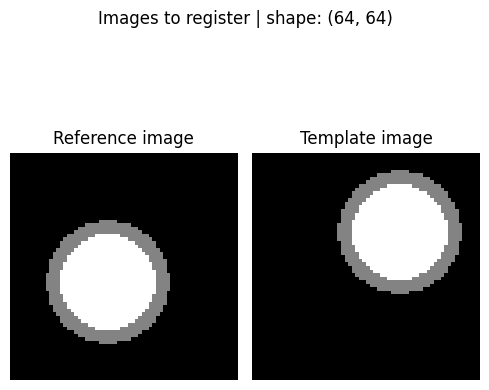

In [42]:
I0 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/lddmm/circle0.png')[:,:,0] / 255
I1 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/lddmm/circle1.png')[:,:,0] / 255

show_images_to_register(I0,I1)

 20/20 | E = 23377.06

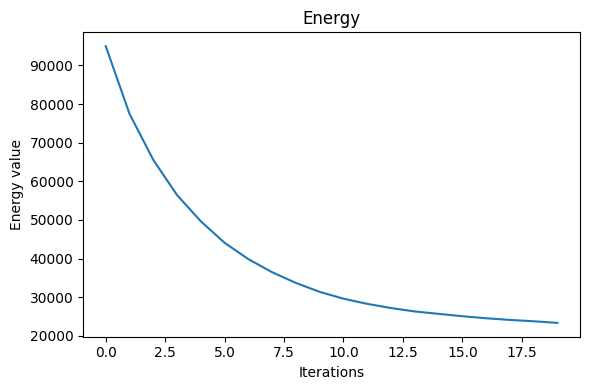

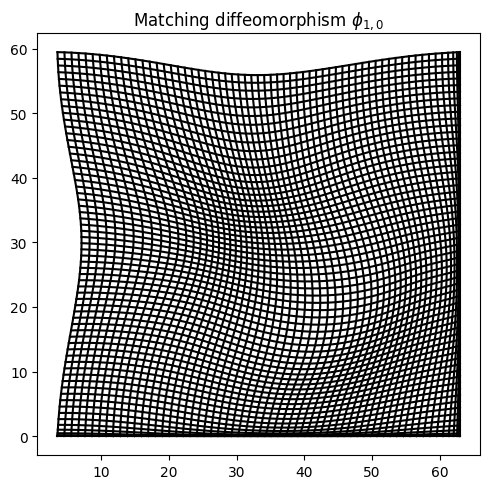

In [51]:
n_iter = 20
lr = 0.1
sigma = 0.1
reg_alpha = 100
reg_gamma = 1
N = 20
delta_t = 0.1

lddmm = LDDMM()
J0, JT, phi_0, phi_T, v, energies, Length = lddmm.compute_deformation(I0, I1, lr=lr, N=N, n_iter=n_iter, delta_t=delta_t, sigma=sigma, reg_alpha=reg_alpha, reg_gamma=reg_gamma)
plot_energy(energies)
plot_diffeomorphism(phi_T[0])

In [52]:
HTML(make_velocities_video(v))

In [ ]:
HTML(make_video(J0))

### Warping

Here we register a disk on a square. Both shapes are approximatively at the same location. The main difference with the previous scenario lies in the value of alpha. As we want to warp the original shape, it has to be "flexible" enough.

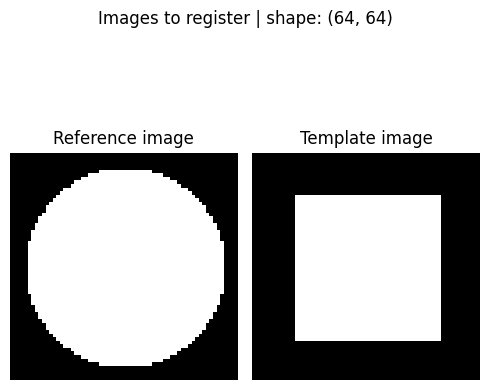

In [23]:
I0 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/lddmm/shape0.png') / 255
I1 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/lddmm/shape1.png') / 255

show_images_to_register(I0, I1)

 60/60 | E = 3875.82

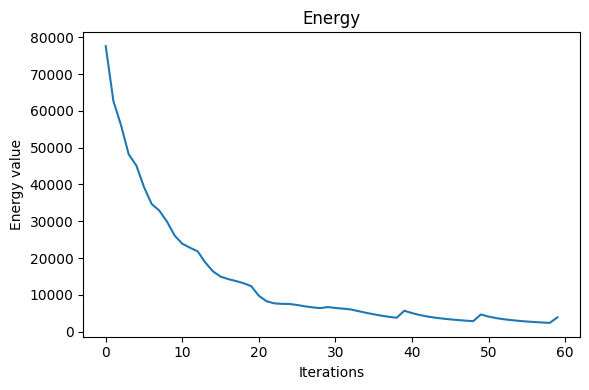

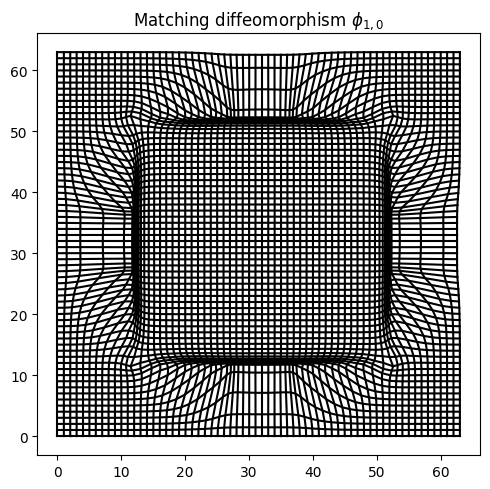

In [32]:
n_iter = 60
lr = 0.002
sigma = 0.1
reg_alpha = 1.
reg_gamma = 1.
N = 20
delta_t = 0.1

lddmm = LDDMM()
J0, JT, phi_0, phi_T, v, energies, Length = lddmm.compute_deformation(I0, I1, lr=lr, N=N, n_iter=n_iter, delta_t=delta_t, sigma=sigma, reg_alpha=reg_alpha, reg_gamma=reg_gamma)
plot_energy(energies)
plot_diffeomorphism(phi_T[0])

In [33]:
HTML(make_video(J0))

In [41]:
HTML(make_velocities_video(v))

### MRI registration

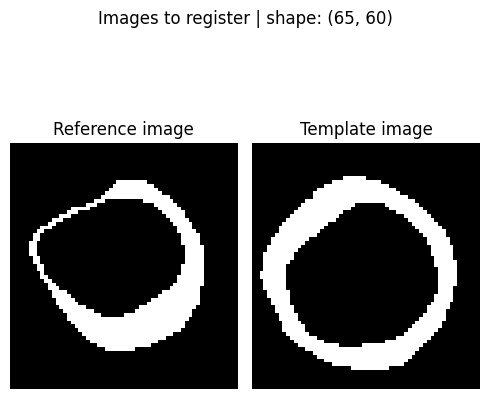

In [ ]:
I0 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/lddmm/ventricle0.png')[90:155,60:120] / 255
I1 = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/lddmm/ventricle1.png')[90:155,60:120] / 255

show_images_to_register(I0,I1)

 150/150 | E = 83559.43

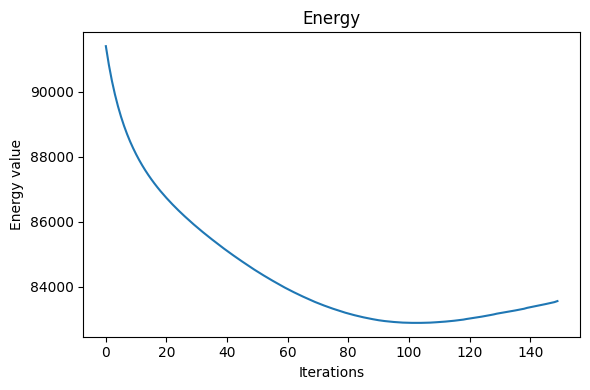

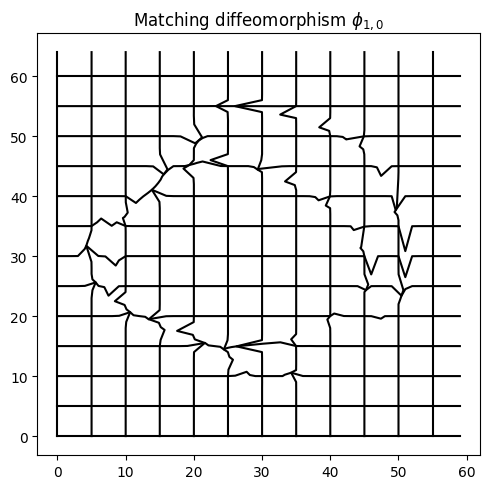

In [ ]:
n_iter = 150
lr = 0.0005
sigma = 0.1
reg_alpha = .01
reg_gamma = 5.
N = 20
delta_t = 0.1

lddmm = LDDMM()
J0, JT, phi_0, phi_T, v, energies, Length = lddmm.compute_deformation(I0, I1, lr=lr, N=N, n_iter=n_iter, delta_t=delta_t, sigma=sigma, reg_alpha=reg_alpha, reg_gamma=reg_gamma)
plot_energy(energies)
plot_diffeomorphism(phi_T[0], step=5)

In [ ]:
HTML(make_video(J0))